<a href="https://colab.research.google.com/github/Witcape/3D_Printing/blob/main/VIT_SRCNN_FINAL_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AarohiSingla/Image-Classification-Using-Vision-transformer
%cd Image-Classification-Using-Vision-transformer

Cloning into 'Image-Classification-Using-Vision-transformer'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 12), reused 8 (delta 8), pack-reused 29 (from 1)
Receiving objects: 100% (43/43), 862.14 KiB | 29.73 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/Image-Classification-Using-Vision-transformer


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['Normal','Spaghetti','Stringing']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 169MB/s]


In [5]:
!pip install torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [6]:
# import os
# from PIL import Image
# from shutil import copytree, ignore_patterns, rmtree

# # Define the base directories
# source_dir = '/content/drive/MyDrive/Final_Final'  # Original dataset
# destination_dir = '/content/Gray'  # Directory to save grayscale images

# # Define subfolders inside train and test directories
# subfolders = ['Normal', 'Spaghetti', 'Stringing']

# # Remove the destination directory if it exists
# if os.path.exists(destination_dir):
#     rmtree(destination_dir)  # Remove the existing directory and its contents

# # Function to convert images in a given folder to grayscale and save in the new location
# def convert_to_grayscale_and_save(src_folder, dest_folder):
#     os.makedirs(dest_folder, exist_ok=True)  # Create the destination folder if it doesn't exist
#     for filename in os.listdir(src_folder):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             src_img_path = os.path.join(src_folder, filename)
#             dest_img_path = os.path.join(dest_folder, filename)

#             img = Image.open(src_img_path).convert('L')  # Convert to grayscale
#             img.save(dest_img_path)  # Save the grayscale image

# # Copy the folder structure from the original dataset to the new destination
# copytree(source_dir, destination_dir, ignore=ignore_patterns('*.png', '*.jpg', '*.jpeg'))

# # Loop through train and test folders and their subfolders
# for folder in ['Train', 'Test']:
#     folder_path = os.path.join(source_dir, folder)
#     for subfolder in subfolders:
#         src_subfolder_path = os.path.join(folder_path, subfolder)
#         dest_subfolder_path = os.path.join(destination_dir, folder, subfolder)
#         convert_to_grayscale_and_save(src_subfolder_path, dest_subfolder_path)

# print("All images converted to grayscale and saved in the new location.")


In [7]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/Final_Final/Train'
test_dir = '/content/drive/MyDrive/Final_Final/Test'

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [9]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [10]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [11]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [12]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8730 | train_acc: 0.6049 | test_loss: 0.6690 | test_acc: 0.7436
Epoch: 2 | train_loss: 0.5054 | train_acc: 0.8326 | test_loss: 0.5417 | test_acc: 0.7845
Epoch: 3 | train_loss: 0.3881 | train_acc: 0.8806 | test_loss: 0.4909 | test_acc: 0.8037
Epoch: 4 | train_loss: 0.3359 | train_acc: 0.9085 | test_loss: 0.4593 | test_acc: 0.8109
Epoch: 5 | train_loss: 0.2858 | train_acc: 0.9196 | test_loss: 0.4359 | test_acc: 0.8181
Epoch: 6 | train_loss: 0.2582 | train_acc: 0.9263 | test_loss: 0.4259 | test_acc: 0.8229
Epoch: 7 | train_loss: 0.2278 | train_acc: 0.9565 | test_loss: 0.4091 | test_acc: 0.8205
Epoch: 8 | train_loss: 0.2002 | train_acc: 0.9643 | test_loss: 0.4092 | test_acc: 0.8413
Epoch: 9 | train_loss: 0.1781 | train_acc: 0.9676 | test_loss: 0.4041 | test_acc: 0.8462
Epoch: 10 | train_loss: 0.1655 | train_acc: 0.9743 | test_loss: 0.3971 | test_acc: 0.8462


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


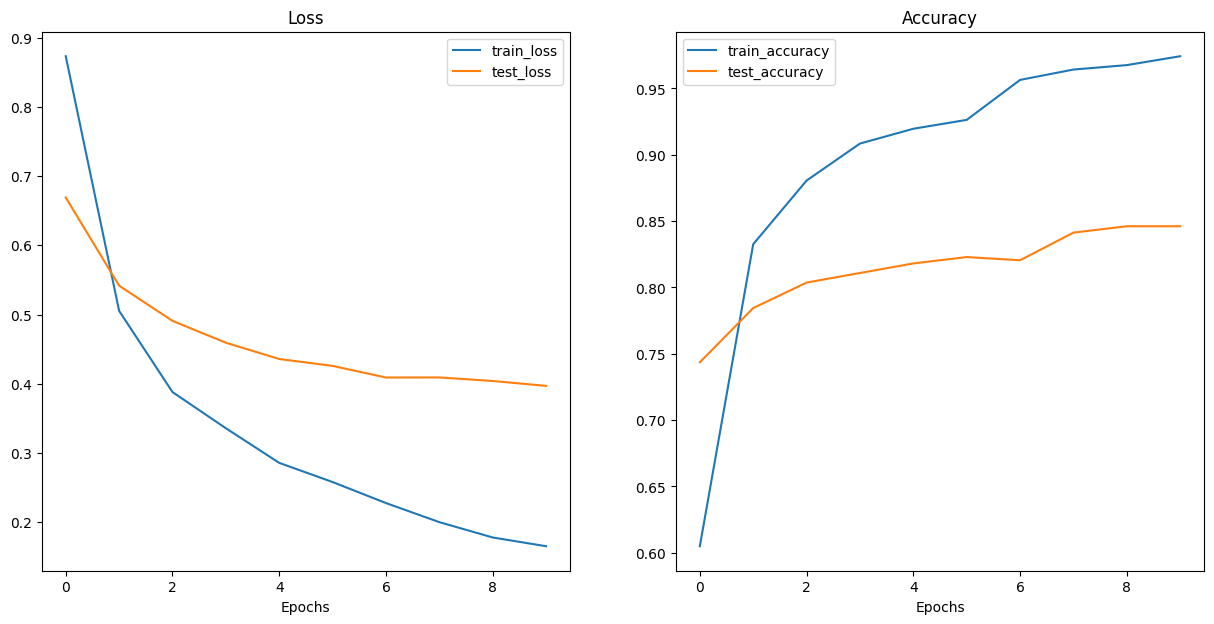

In [13]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [14]:
# Set model to evaluation mode
pretrained_vit.eval()

# Disable gradient calculations (inference only)
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_dataloader_pretrained:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: Get predictions
        outputs = pretrained_vit(images)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = correct / total * 100
print(f'Accuracy on the test dataset: {accuracy:.2f}%')


Accuracy on the test dataset: 83.46%


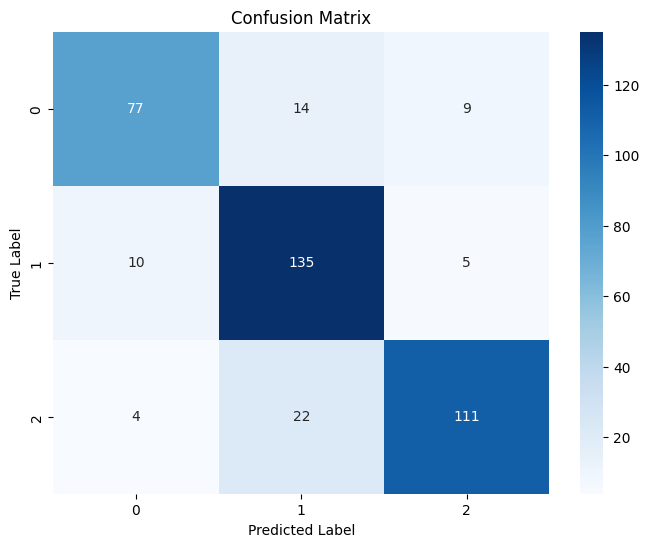

In [15]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
pretrained_vit.eval()

# Disable gradient calculations (inference only)
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader_pretrained:
        images, labels = images.to(device), labels.to(device)

        # Forward pass: Get predictions
        outputs = pretrained_vit(images)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

In [16]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Final_Final/Normal/OK_69_jpg.rf.ae140d85c8b3a30a329d976e6204418d.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final_Final/Normal/OK_69_jpg.rf.ae140d85c8b3a30a329d976e6204418d.jpg'

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Final_Final/Test/Spaghetti/PXL_20210304_123630223_jpg.rf.b7903f80e91c2895c9c5f4d43ca46fbc.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/Final_Final/Test/Stringing/199637503_1691583127708765_7776554622696581688_n_jpg.rf.9e6342e2b5981a29b43c7cd2e8a004e7.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [17]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/normal.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

FileNotFoundError: [Errno 2] No such file or directory: '/content/normal.jpg'

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/normal_trick_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/spaghetti_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/stringing_2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/normal_printer_view_1"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/normal_printer_view_2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/spghetti_printer_view_2.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/strining_printer_view_1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)